# Getting started with CoAuthor

**Goal: Download and read the CoAuthor dataset**

Steps
1. Download CoAuthor
2. Read writing sessions
3. Examine events

Below sections of this .ipynb come from code from CoAuthor [LINKED HERE](https://colab.research.google.com/drive/1nUGXP9l_jelbB4X65J0ivUvLgQz1RK1C?usp=sharing)

* Download CoAuthor
* Read writing sessions
* Examine events



## 1. Download CoAuthor

In [1]:
!wget https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip
!unzip -q chi2022-coauthor-v1.0.zip
!rm chi2022-coauthor-v1.0.zip

--2025-03-08 17:20:16--  https://cs.stanford.edu/~minalee/zip/chi2022-coauthor-v1.0.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49956179 (48M) [application/zip]
Saving to: ‘chi2022-coauthor-v1.0.zip’

chi2022-coauthor-v1 100%[===================>]  47.64M  8.27MB/s    in 5.4s    

2025-03-08 17:20:22 (8.89 MB/s) - ‘chi2022-coauthor-v1.0.zip’ saved [49956179/49956179]



In [3]:
import os

dataset_dir = './coauthor-v1.0'
paths = [
    os.path.join(dataset_dir, path)
    for path in os.listdir(dataset_dir)
    if path.endswith('jsonl')
]

print(f'Successfully downloaded {len(paths)} writing sessions in CoAuthor!')

Successfully downloaded 1447 writing sessions in CoAuthor!


## 2. Read writing sessions

Each writing session is saved as a `.jsonl` file in CoAuthor.
It is a very convenient format to store events occured in the writing session: each line is a JSON object, representing an *event*, and there are many lines in the file, representing *a sequence of events*.

Let's read one of the files and see what it looks like!

> `.jsonl` is the JSON Lines text format. It is convenient for storing structured data that may be processed one record at a time. For more information, please refer to https://jsonlines.org/.

In [4]:
import json

def read_writing_session(path):
    events = []
    with open(path, 'r') as f:
        for event in f:
            events.append(json.loads(event))
    print(f'Successfully read {len(events)} events in a writing session from {path}')
    return events

In [5]:
events = read_writing_session(paths[0])

Successfully read 1443 events in a writing session from ./coauthor-v1.0/91366311bd76400b9ea7efe17bf8b659.jsonl


## 3. Examine events

Whenever writers insert or delete text, move a cursor forward or backward, get suggestions from the system by pressing the tab key, or accept or dismiss suggestions, it is recorded as an event.

> Here is a list of all possible events in CoAuthor:
* `system-initialize`
* `text-insert`
* `text-delete`
* `cursor-forward`
* `cursor-backward`
* `cursor-select`
* `suggestion-get`
* `suggestion-open`
* `suggestion-up`
* `suggestion-down`
* `suggestion-select`
* `suggestion-close`

For more details, please check out our paper (Table 1): https://arxiv.org/pdf/2201.06796.pdf

In [6]:
event_names = [event['eventName'] for event in events]
event_names[:10]

['system-initialize',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-insert',
 'text-insert']

Let's look at each *event* more closely now!

In the beginning of a writing session, you will see something like this for a system-initialize event:

In [7]:
events[0]

{'eventName': 'system-initialize',
 'eventSource': 'api',
 'eventTimestamp': 1629598425078,
 'textDelta': '',
 'cursorRange': '',
 'currentDoc': 'How Do You Think Technology Affects Dating?\n\nHave you had any experience with dating? Have you ever used dating apps? If so, what has it been like for you? If not, why not?\n\nHow do you think technology — like apps, Netflix, social media and texting — affects dating and relationships? In your opinion, does it improve or worsen romantic interactions? How so?\n\n---\n\nIn my opinion,\n',
 'currentCursor': 379,
 'currentSuggestions': [],
 'currentSuggestionIndex': 0,
 'currentHoverIndex': '',
 'currentN': '5',
 'currentMaxToken': '30',
 'currentTemperature': '0.2',
 'currentTopP': '1',
 'currentPresencePenalty': '0',
 'currentFrequencyPenalty': '0.5',
 'eventNum': 0}

Concretely, an *event* is a tuple of event name, timestamp, and snapshot of the current editor.
This is designed to preserve every detail about interactions at a keystroke-level, so it is quite detailed as you can see!

> **Event and its metadata**
* `eventName`: event name (e.g. `system-initialize`)
* `eventSource`: event source (e.g. `user` or `api`)
* `textDelta`: text that has been changed compared to the previous event (if no change, empty)
* `cursorRange`: cursor location or selection that has been changed compared to the previous event (if no change, empty)

> **Timestamp**
* `eventTimestamp`: timestamp of the event
* `eventNum`: index of the event

> **Snapshot of the current editor**
* Editor
  * `currentDoc`: a writing prompt to start with (otherwise, empty)
  * `currentCursor`: cursor location
  * `currentSuggestions`: most recent suggestions that are stored and can be reopened
* Decoding parameters
  * `currentN`: the number of suggestions to generate per query (e.g. 5)
  * `currentMaxToken`: the maximum number of tokens to generate per suggestion
  * `currentTemperature`: sampling temperature to use for generation; higher values means the model will take more risks
  * `currentTopP`: nucleus sampling; the model considers the results of the tokens with top_p probability mass
  * `currentPresencePenalty`: positive values penalize new tokens based on whether they appear in the text so far, increasing the model's likelihood to talk about new topics
  * `currentFrequencyPenalty`: positive values penalize new tokens based on their existing frequency in the text so far, decreasing the model's likelihood to repeat the same line verbatim


For more details on decoding parameters, please refer to https://beta.openai.com/docs/api-reference/completions.

## 4. Detecting Tone

Here we use RoBERTa GoEmotions for our emotion classifier. Downloading the model here.

In [8]:
from transformers import pipeline

# Load emotion classification model
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [9]:
text = "The weather is especially warm today."
result = emotion_classifier(text)
print(result)

[[{'label': 'anger', 'score': 0.06616844981908798}, {'label': 'disgust', 'score': 0.13412681221961975}, {'label': 'fear', 'score': 0.01607241854071617}, {'label': 'joy', 'score': 0.009524280205368996}, {'label': 'neutral', 'score': 0.3987541198730469}, {'label': 'sadness', 'score': 0.36784031987190247}, {'label': 'surprise', 'score': 0.007513641845434904}]]


Function to get the emotion label and score for top six emotions: anger, disgust, fear, joy, neutral, sadness, and surprise

In [11]:
def get_emotion_vector(text):
  result = emotion_classifier(text)[0]
  scores = {emotion['label']: emotion['score'] for emotion in result}
  return scores, np.array(list(scores.values()))

## 5. Calculating Similarity of Tone Vectors - Jensen-Shannon Divergence (JSD)

Here I am downloading Jensen-Shannon Divergence as the method to calculate similarity of the tone portfolios that we will capture with Go Emotions.

In [12]:
from scipy.spatial.distance import jensenshannon

def similarity_jsd(vector1, vector2):
    ''' Calculate JSD similarity between two vectors.'''
    jsd =  jensenshannon(vector1, vector2)
    similarity = 1 - jsd
    return similarity

In [13]:
import numpy as np
prompt = "I love when my dogs are excited to go for a walk. It makes the walks much more enjoyable."
suggestion = "That is why I always bring their favorite stuffed animals out to get them ready to go for a fun walk."

score1, v1 = get_emotion_vector(prompt)
score2, v2 = get_emotion_vector(suggestion)
similarity_jsd(v1, v2)

0.6319316171294749

In [14]:
print(score1)
print(v1)

{'anger': 0.0022996123880147934, 'disgust': 0.0035732020623981953, 'fear': 0.00047727618948556483, 'joy': 0.9764875173568726, 'neutral': 0.011999444104731083, 'sadness': 0.0032281221356242895, 'surprise': 0.0019348839996382594}
[2.29961239e-03 3.57320206e-03 4.77276189e-04 9.76487517e-01
 1.19994441e-02 3.22812214e-03 1.93488400e-03]


In [15]:
print(score2)
print(v2)

{'anger': 0.009798532351851463, 'disgust': 0.008384371176362038, 'fear': 0.0014324390795081854, 'joy': 0.5880451202392578, 'neutral': 0.3717357814311981, 'sadness': 0.006140437442809343, 'surprise': 0.014463272877037525}
[0.00979853 0.00838437 0.00143244 0.58804512 0.37173578 0.00614044
 0.01446327]


## 6. Creating and Visualizing Tone Similarity between CoAuthor Prompts

In [16]:
# understanding what each event contains
events[523]

{'eventName': 'text-insert',
 'eventSource': 'user',
 'eventTimestamp': 1629598693978,
 'textDelta': {'ops': [{'retain': 1332}, {'insert': 'a'}]},
 'cursorRange': '',
 'currentDoc': '',
 'currentCursor': 1333,
 'currentSuggestions': [],
 'currentSuggestionIndex': 0,
 'currentHoverIndex': 0,
 'currentN': '5',
 'currentMaxToken': '30',
 'currentTemperature': '0.2',
 'currentTopP': '1',
 'currentPresencePenalty': '0',
 'currentFrequencyPenalty': '0.5',
 'eventNum': 523}


User Input (User-Generated Text)
*   text-insert
*   text-delete

AI Suggestions (Model-Generated Text)
*   suggestion-get
*   suggestion-open
*  suggestion-select






This chunk of code combines the previous tasks, including finding tone and similarity between two tones and calculating it for every event.

In [17]:
from collections import defaultdict

def reconstruct_user_text(events):
    ''' Creates text from events by combining text-insert and text-delete events.'''
    user_texts = []
    current_text = ""

    # Sort events by eventNum
    sorted_events = sorted(events, key=lambda e: e["eventNum"])

    for event in sorted_events:
        event_type = event["eventName"]
        text_delta = event["textDelta"]

        if event_type == "text-insert" and text_delta:
            extracted_text = ""
            for op in text_delta['ops']:
                if 'insert' in op:
                    extracted_text += op['insert']
            current_text += extracted_text

        elif event_type == "text-delete" and text_delta:
            delete_len = 0
            for op in text_delta['ops']:
                if 'delete' in op:
                    delete_len += op['delete']
                elif 'retain' in op:
                    pass
            current_text = current_text[:-delete_len]


        # Store finalized text if user completes a thought
        if event_type == "suggestion-get" or event_type == "suggestion-select":
            if current_text.strip():
                user_texts.append(current_text.strip())
                current_text = ""

    return user_texts

# Process all valid events
user_texts = reconstruct_user_text(events)

print(f"Total reconstructed user-written sentences: {len(user_texts)}")
print("Example user-written sentence:", user_texts)  # Show first 3 examples

Total reconstructed user-written sentences: 34
Example user-written sentence: ['technology', 'has made dating and relationships easier. My experience with dating apps', 'has been great. Thanks to Tinder and OKcupid, I have', 'been able to meet and date some really cool people. In fact,', 'I am currently dating someone I met on Tinder. I met her', 'at a bar, but we connected on Tinder first. The date went', 'well and we have been seeing each other ever since.firskC I think that', 'we', "would have never met if it weren't for Tinder. I believe this relationship", 'will last because we have a lot in common and we are both very similar.\n\nWhen it comes to Netflix, I think the effect on dating and relationships', 'is neutral, and trivial. Before Netflix,', 'people would go out to the movies, or rent a movie, or watch TV. on dates Netflix is just', 'another way to do that, the 21st', 'century way. in general\n\nSocial Media', 'has made it easier to stay in touch with friends and family, and

This function is used to get the ai-suggestions

In [18]:
def extract_selected_ai_suggestions(events):
    ai_suggestions = []  # Stores accepted AI-generated suggestions
    last_suggestion_open = None  # Store the most recent `suggestion-open` event

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save latest `suggestion-open` event

        elif event["eventName"] == "suggestion-select":
            if last_suggestion_open and last_suggestion_open.get("currentSuggestions"):
                selected_index = event.get("currentSuggestionIndex", -1)

                # Ensure selected index is valid
                if 0 <= selected_index < len(last_suggestion_open["currentSuggestions"]):
                    selected_suggestion = last_suggestion_open["currentSuggestions"][selected_index]["trimmed"]
                    ai_suggestions.append(selected_suggestion)

    return ai_suggestions

# Process all valid events
ai_suggestions = extract_selected_ai_suggestions(events)

print(f"Total AI Suggestions Accepted: {len(ai_suggestions)}")
print("Example AI Suggestion:", ai_suggestions[:3])  # Show first 3 examples


Total AI Suggestions Accepted: 29
Example AI Suggestion: ['has made dating easier.', 'has been positive.', 'met many people and have had a lot of fun.']


Here you can run this code to create a dataframe which contains the user text, ai-suggestion, and the tone similarity score.

In [19]:
import pandas as pd
jsd_results = []
small = paths[100:110]
for path in small:
    events = read_writing_session(path)

    # Extract user-written text and AI-generated suggestions
    user_texts = reconstruct_user_text(events)
    ai_suggestions = extract_selected_ai_suggestions(events)
    print(f"User-written sentences: {user_texts}")
    print(f"AI-generated suggestions: {ai_suggestions}")

    # Ensure we only compare matching pairs
    for user_text, ai_text in zip(user_texts, ai_suggestions):
        user_score, user_vector = get_emotion_vector(user_text)
        ai_score, ai_vector = get_emotion_vector(ai_text)

        # Compute JSD similarity
        jsd_similarity = similarity_jsd(user_vector, ai_vector)

        # Store results
        jsd_results.append({
            "path": path,
            "user_text": user_text,
            "ai_suggestion": ai_text,
            "jsd_similarity": jsd_similarity
        })

# Save results to CSV
df_results = pd.DataFrame(jsd_results)

print(f"Processed {len(paths)} paths. Results saved to emotion_similarity_results.csv.")

Successfully read 2196 events in a writing session from ./coauthor-v1.0/dfbab4c8263444ef9d9e9d25e3e581f4.jsonl
User-written sentences: ["THe aliends knew the Earth wasn't very advanced.But their research had also shown them that humans tended to be violent, self confident, and sometimes even resourceful when they were deperate. But the aliend just never thought it would go like this.", 'The aliens let out a sigh and picked up the phone, dialing Matt Damon\'s agent.\n\n "Yes, re reived you lasteceived rmessage. Yes, we know we haven\'t signed the appearance contract. YessAnd the... 57 before that. , we know there is an extra fee for out od country work. Yes we received your rider requirements. Human, do you not know who we are? What we can do to you?"', 'Alien: Right click  ", you $(#*^&#*$&" The commander hung up on Matt Damon\'s agent (again) and turned to the cursing crew man. "They won\'t stop with the scam calls Sir! This one keep saying he was from Microsoft and they had reports w

This is used to better understand the distribution of `event_name` in a path.

In [20]:
from collections import Counter

event_counts = Counter()

# Check event type distribution
for path in paths[:100]:  # Only first 100 paths
    events = read_writing_session(path)
    for event in events:
        event_counts[event["eventName"]] += 1

print("Event Distribution in First 100 Paths:")
for event_name, count in event_counts.items():
    print(f"{event_name}: {count}")

Successfully read 1443 events in a writing session from ./coauthor-v1.0/91366311bd76400b9ea7efe17bf8b659.jsonl
Successfully read 758 events in a writing session from ./coauthor-v1.0/1c5622c21c424b91a8325faa0c5e753e.jsonl
Successfully read 1578 events in a writing session from ./coauthor-v1.0/4cf7657748194823a3c4349e8a469c99.jsonl
Successfully read 1364 events in a writing session from ./coauthor-v1.0/b8be5a82533b406bbf13aaa587a8d924.jsonl
Successfully read 1991 events in a writing session from ./coauthor-v1.0/b36defcb6838467db4486349793492fc.jsonl
Successfully read 2361 events in a writing session from ./coauthor-v1.0/e76e0164df714bae95772dba5e3d7a5f.jsonl
Successfully read 3460 events in a writing session from ./coauthor-v1.0/4bdb5a30d17d40d7b160d942552c190b.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 3027 events in a writing session from ./coauthor-v1.0/c4e852c4b21b4703a485d93b618361cd.jsonl
Su

In [21]:
#looking at event where eventName is suggestion-select
for event in events:
  if event['eventName'] == 'suggestion-open':
    print(event)
  if event['eventName'] == 'suggestion-select':
    print(event)
  if event['eventName'] == 'suggestion-close':
    print(event)


{'eventName': 'suggestion-open', 'eventSource': 'api', 'eventTimestamp': 1629199626656, 'textDelta': '', 'cursorRange': '', 'currentDoc': '', 'currentCursor': 846, 'currentSuggestions': [{'index': 0, 'original': '\n\nThe 92nd little pig and the wolf began a long and tedious construction project.', 'trimmed': 'The 92nd little pig and the wolf began a long and tedious construction project.', 'probability': 9.348164729688369e-25}, {'index': 1, 'original': '\n\nBigger, badder wolves were immediately sent out to handle the little pigs.', 'trimmed': 'Bigger, badder wolves were immediately sent out to handle the little pigs.', 'probability': 3.436641811448337e-27}, {'index': 2, 'original': '\n\nSo the 92nd pig got all of his little piggies together and they formed a huge militia.', 'trimmed': 'So the 92nd pig got all of his little piggies together and they formed a huge militia.', 'probability': 1.3472823499403766e-19}, {'index': 3, 'original': '\n\nSo the 92nd little pig said, "hey wolf.', '

## 7. Visualizing Results

In [22]:
# highest and lowest 5 similarity scores and text
highest_5 = df_results.nlargest(5, 'jsd_similarity')
lowest_5 = df_results.nsmallest(5, 'jsd_similarity')
print("Highest 5 Similarity Scores:")
for index, row in highest_5.iterrows():
    print(f"Score: {row['jsd_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


print("\nLowest 5 Similarity Scores:")
for index, row in lowest_5.iterrows():
    print(f"Score: {row['jsd_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


Highest 5 Similarity Scores:
Score: 0.9614272252723977
User Text: "I'm not going to sting you, Your Majesty," the bee said.
 "Well then tell me, what do you want?", I asked the bee.
AI Suggestion: "I'm not going to sting you, Your Majesty," the bee said.
Score: 0.9479226992700573
User Text: She has to learn to love herself before she can let anyone else in and be happy.
AI Suggestion: She’s never going to find love until she learns to love herself.
Score: 0.8854912790798146
User Text: He decided to keep it a secret, and not tell anyone. Perhaps it was best that magic was forgotten in the past. Given the state of the world, what may happen, he thought if people learned magic. Isaac placed the tome in a chest he owned, and locked it for good. Although it would appear to him every now and then, he decided to keep his promise, and keep it out of the eyes of others.
AI Suggestion: He decided to keep it a secret, and not tell anyone.
Score: 0.8825023945024968
User Text: "I'm here to help you

Function to identify whether the user accepted or rejected a suggestion from ai.

In [23]:
def extract_acceptance_status(events):
    """Track if a suggestion was accepted or rejected."""
    acceptance_status = []  # Stores 'accepted' or 'rejected'
    last_suggestion_open = None  # Store the most recent `suggestion-open`

    for event in events:
        if event["eventName"] == "suggestion-open" and event.get("currentSuggestions"):
            last_suggestion_open = event  # Save the latest `suggestion-open`

        elif event["eventName"] == "suggestion-select" and last_suggestion_open:
            # Suggestion selected
            acceptance_status.append('accepted')
            last_suggestion_open = None  # Reset, since we handled the acceptance

        elif event["eventName"] == "suggestion-close" and last_suggestion_open:
            # Suggestion closed without selection (rejected)
            acceptance_status.append('rejected')
            last_suggestion_open = None  # Reset, since we handled the rejection

    return acceptance_status

Create a dataframe with user text, ai-suggestion, tone similarity, and

In [24]:
# Loop through each path (limited to paths 100-110)
for path in paths[:100]:
    events = read_writing_session(path)

    if len(events) < 3000:

      # Extract user-written text and AI-generated suggestions
      user_texts = reconstruct_user_text(events)
      ai_suggestions = extract_selected_ai_suggestions(events)
      acceptance_status = extract_acceptance_status(events)

      # Ensure we only compare matching pairs
      for user_text, ai_text, status in zip(user_texts, ai_suggestions, acceptance_status):
          user_score,user_vector = get_emotion_vector(user_text)
          ai_score,ai_vector = get_emotion_vector(ai_text)

          # Compute JSD similarity
          jsd_similarity = similarity_jsd(user_vector, ai_vector)

          # Store results, including acceptance status
          jsd_results.append({
              "path": path,
              "user_text": user_text,
              "ai_suggestion": ai_text,
              "tone_similarity": jsd_similarity,
              "acceptance_status": status
          })


Successfully read 1443 events in a writing session from ./coauthor-v1.0/91366311bd76400b9ea7efe17bf8b659.jsonl
Successfully read 758 events in a writing session from ./coauthor-v1.0/1c5622c21c424b91a8325faa0c5e753e.jsonl
Successfully read 1578 events in a writing session from ./coauthor-v1.0/4cf7657748194823a3c4349e8a469c99.jsonl
Successfully read 1364 events in a writing session from ./coauthor-v1.0/b8be5a82533b406bbf13aaa587a8d924.jsonl
Successfully read 1991 events in a writing session from ./coauthor-v1.0/b36defcb6838467db4486349793492fc.jsonl
Successfully read 2361 events in a writing session from ./coauthor-v1.0/e76e0164df714bae95772dba5e3d7a5f.jsonl
Successfully read 3460 events in a writing session from ./coauthor-v1.0/4bdb5a30d17d40d7b160d942552c190b.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 3027 events in a writing session from ./coauthor-v1.0/c4e852c4b21b4703a485d93b618361cd.jsonl
Su

In [25]:
# Save results to CSV
df_results_with_acceptances = pd.DataFrame(jsd_results)

print(f"Processed {len(small)} paths. Results saved to emotion_similarity_with_acceptance.csv.")


Processed 10 paths. Results saved to emotion_similarity_with_acceptance.csv.


Looking at the highest and lowest 5 similarity scores

In [28]:
# highest and lowest 5 similarity scores and text
#highest five after similarity of 1
highest_5 = df_results_with_acceptances[df_results_with_acceptances['tone_similarity'] < 1].nlargest(5, 'tone_similarity')
lowest_5 = df_results_with_acceptances.nsmallest(5, 'tone_similarity')
print("Highest 5 Similarity Scores:")
for index, row in highest_5.iterrows():
    print(f"Score: {row['tone_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")


print("\nLowest 5 Similarity Scores:")
for index, row in lowest_5.iterrows():
    print(f"Score: {row['tone_similarity']}")
    print(f"User Text: {row['user_text']}")
    print(f"AI Suggestion: {row['ai_suggestion']}")

Highest 5 Similarity Scores:
Score: 0.9788488232769919
User Text: "A bee-human hybrid, yes.
"
AI Suggestion: "A bee-human hybrid, yes.
Score: 0.973009102869352
User Text: You are all here, so it must be one of those

I wonder if these yous are good people or bad people?  Do we all share a common core personality?
AI Suggestion: You wonder if you will ever meet up with any of these yous again.
Score: 0.9625416128518796
User Text: On online dating sites, you also have the opportunity to use profile photos, multiple photos and a range of writing styles to help choose a mate.
AI Suggestion: Tinder and other dating apps allow you to quickly evaluate a large number of potential partners in a short period of time.
Score: 0.9562184897607741
User Text: the most offensive portrayal of a person is the one that makes them seem like a stereotype. This type of portrayal shows no creativity at all. There is no substance behind characters like this which in my opinion shows a lack of work ethic and cr

### Visualizations

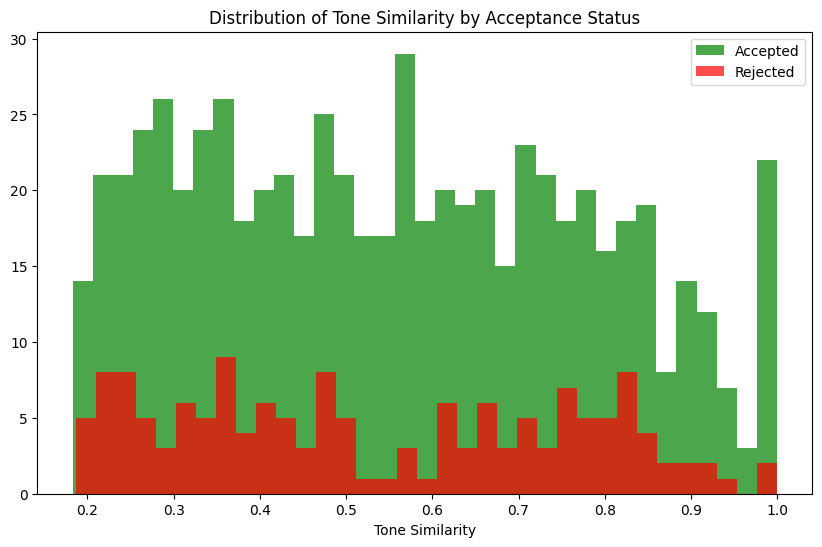

In [30]:
# plot of similarity distribution by acceptance status
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_results_with_acceptances[df_results_with_acceptances['acceptance_status'] == 'accepted']['tone_similarity'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results_with_acceptances[df_results_with_acceptances['acceptance_status'] == 'rejected']['tone_similarity'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of Tone Similarity by Acceptance Status')
plt.xlabel('Tone Similarity')
plt.legend()

## 8. Looking into POS for user and ai-generated text

two different ways to analyze Part of Speech structure. By frequency and order.

In [31]:
import spacy
from typing import List, Dict

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def get_pos_sequence(text):
    """Extracts the POS tag sequence from a given text."""
    doc = nlp(text)
    return [token.pos_ for token in doc]

def compare_pos_sequences(user_text, ai_text):
    """Compares POS tag sequences from user and AI text."""
    user_pos = get_pos_sequence(user_text)
    ai_pos = get_pos_sequence(ai_text)
    return {"user_pos": user_pos, "ai_pos": ai_pos}

def get_pos_frequencies(text):
    """Calculates the frequency of each POS tag in the given text."""
    pos_tags = get_pos_sequence(text)
    return dict(Counter(pos_tags))

def compare_pos_frequencies(user_text, ai_text):
    """Compares POS tag frequencies between user and AI text."""
    user_freq = get_pos_frequencies(user_text)
    ai_freq = get_pos_frequencies(ai_text)
    return {"user_freq": user_freq, "ai_freq": ai_freq}

# Example usage
user_text = "I love dancing with my friends because it is fun."
ai_text = "Dancing with my friends is enjoyable and stress-relieving."

pos_comparison = compare_pos_sequences(user_text, ai_text)
freq_comparison = compare_pos_frequencies(user_text, ai_text)

print("POS Tag Sequences:", pos_comparison)
print("POS Tag Frequencies:", freq_comparison)

POS Tag Sequences: {'user_pos': ['PRON', 'VERB', 'VERB', 'ADP', 'PRON', 'NOUN', 'SCONJ', 'PRON', 'AUX', 'ADJ', 'PUNCT'], 'ai_pos': ['VERB', 'ADP', 'PRON', 'NOUN', 'AUX', 'ADJ', 'CCONJ', 'NOUN', 'PUNCT', 'NOUN', 'PUNCT']}
POS Tag Frequencies: {'user_freq': {'PRON': 3, 'VERB': 2, 'ADP': 1, 'NOUN': 1, 'SCONJ': 1, 'AUX': 1, 'ADJ': 1, 'PUNCT': 1}, 'ai_freq': {'VERB': 1, 'ADP': 1, 'PRON': 1, 'NOUN': 3, 'AUX': 1, 'ADJ': 1, 'CCONJ': 1, 'PUNCT': 2}}


Function to calculate cosine similarity between POS of texts

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
def cosine_similarity_pos(pos1, pos2):
    """Computes cosine similarity between POS tag frequency vectors."""
    pos1_freq = Counter(pos1)
    pos2_freq = Counter(pos2)

    # Create a sorted list of all POS tags in both texts
    all_tags = sorted(set(pos1_freq.keys()) | set(pos2_freq.keys()))

    # Convert frequency dictionaries into vectors
    vec1 = np.array([pos1_freq.get(tag, 0) for tag in all_tags]).reshape(1, -1)
    vec2 = np.array([pos2_freq.get(tag, 0) for tag in all_tags]).reshape(1, -1)

    # Compute cosine similarity
    return cosine_similarity(vec1, vec2)[0][0]

user_pos = get_pos_sequence(user_text)
ai_pos = get_pos_sequence(ai_text)

print(f"POS Tag Similarity: {cosine_similarity_pos(user_pos, ai_pos)}")

POS Tag Similarity: 0.6842105263157894


### MOST IMPORTANT
Creates the dataframe with user text, ai-suggestion, Tone similarity and POS similarity.

In [53]:
jsd_results = []
# Loop through each path (limited to paths 100-110)
for path in paths[:500]:
    events = read_writing_session(path)

    if len(events) < 3000:

      # Extract user-written text and AI-generated suggestions
      user_texts = reconstruct_user_text(events)
      ai_suggestions = extract_selected_ai_suggestions(events)
      acceptance_status = extract_acceptance_status(events)

      # Ensure we only compare matching pairs
      for user_text, ai_text, status in zip(user_texts, ai_suggestions, acceptance_status):
          user_score,user_vector = get_emotion_vector(user_text)
          ai_score,ai_vector = get_emotion_vector(ai_text)

          # Compute JSD similarity
          jsd_similarity = similarity_jsd(user_vector, ai_vector)

          # Compute POS similarity
          user_pos = get_pos_sequence(user_text)
          ai_pos = get_pos_sequence(ai_text)
          pos_similarity = cosine_similarity_pos(user_pos, ai_pos)

          # Store results, including acceptance status
          jsd_results.append({
              "path": path,
              "user_text": user_text,
              "ai_suggestion": ai_text,
              "tone_similarity": jsd_similarity,
              "pos_similarity": pos_similarity,
              "acceptance_status": status
          })

# Save results to CSV
df_results_with_acceptances = pd.DataFrame(jsd_results)
#df_results_with_acceptances.to_csv("Tone_POS_similarity.csv", index=False)

print(f"Processed {len(small)} paths. Results saved to emotion_similarity_with_acceptance.csv.")


Successfully read 1443 events in a writing session from ./coauthor-v1.0/91366311bd76400b9ea7efe17bf8b659.jsonl
Successfully read 758 events in a writing session from ./coauthor-v1.0/1c5622c21c424b91a8325faa0c5e753e.jsonl
Successfully read 1578 events in a writing session from ./coauthor-v1.0/4cf7657748194823a3c4349e8a469c99.jsonl
Successfully read 1364 events in a writing session from ./coauthor-v1.0/b8be5a82533b406bbf13aaa587a8d924.jsonl
Successfully read 1991 events in a writing session from ./coauthor-v1.0/b36defcb6838467db4486349793492fc.jsonl
Successfully read 2361 events in a writing session from ./coauthor-v1.0/e76e0164df714bae95772dba5e3d7a5f.jsonl
Successfully read 3460 events in a writing session from ./coauthor-v1.0/4bdb5a30d17d40d7b160d942552c190b.jsonl
Successfully read 1202 events in a writing session from ./coauthor-v1.0/bd632b8b53394b32a6dba18848f787a4.jsonl
Successfully read 3027 events in a writing session from ./coauthor-v1.0/c4e852c4b21b4703a485d93b618361cd.jsonl
Su

### Visualizations

Text(0.5, 1.0, 'Scatter Plot of TONE Similarity vs. POS Similarity')

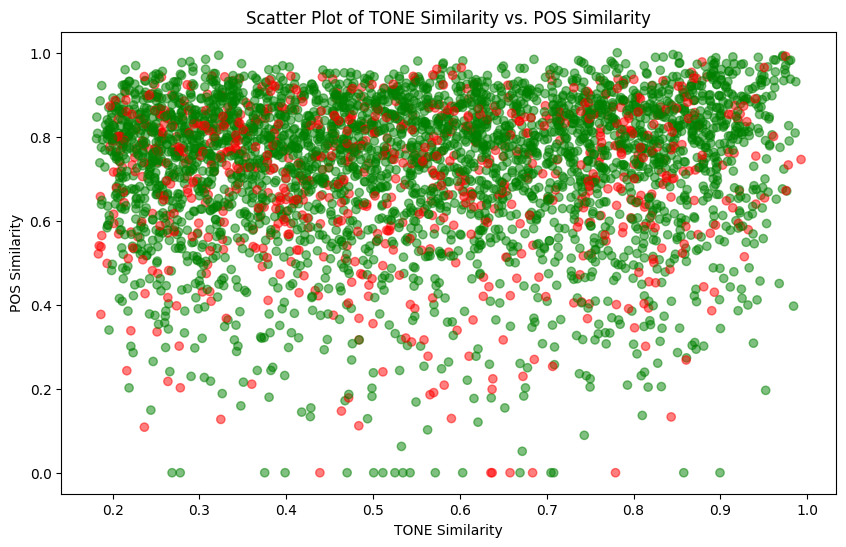

In [55]:
df_results = df_results_with_acceptances[df_results_with_acceptances['tone_similarity'] < 1]
df_results = df_results[df_results['pos_similarity'] < 1]
df_results = df_results.dropna()
df_results.to_csv("Tone_POS_similarity.csv", index=False)

colors = {'accepted': 'green', 'rejected': 'red'}

#plot tone and POS similarity
plt.figure(figsize=(10, 6))
plt.scatter(df_results['tone_similarity'], df_results['pos_similarity'],
            alpha=0.5,
            c=df_results['acceptance_status'].map(colors))
plt.xlabel('TONE Similarity')
plt.ylabel('POS Similarity')
plt.title('Scatter Plot of TONE Similarity vs. POS Similarity')

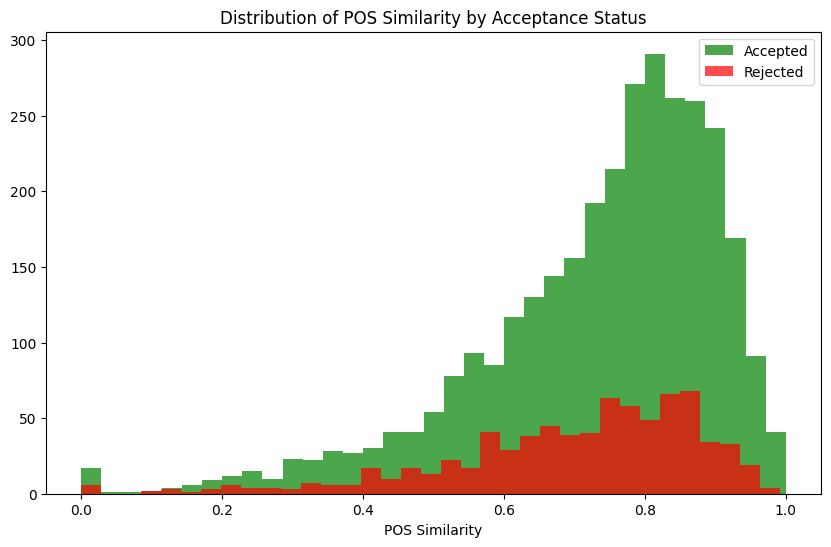

In [56]:
plt.figure(figsize=(10, 6))
plt.hist(df_results[df_results['acceptance_status'] == 'accepted']['pos_similarity'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results[df_results['acceptance_status'] == 'rejected']['pos_similarity'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of POS Similarity by Acceptance Status')
plt.xlabel('POS Similarity')
plt.legend()

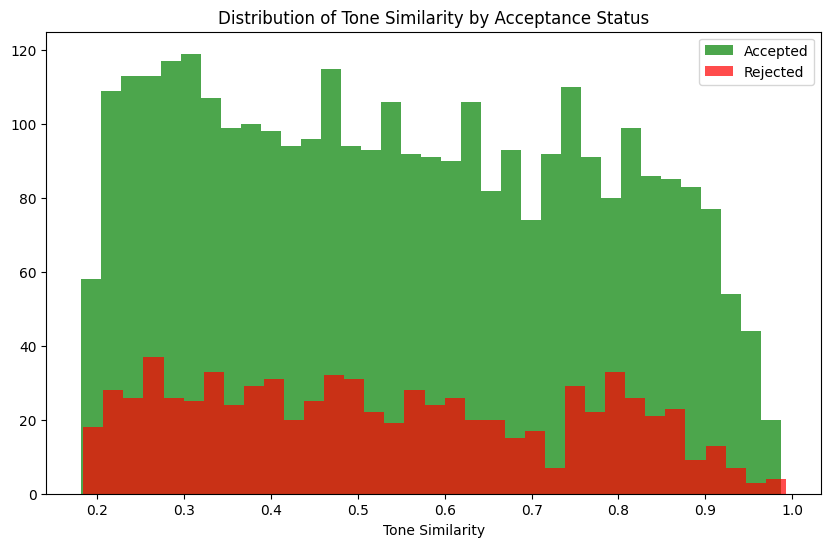

In [57]:
plt.figure(figsize=(10, 6))
plt.hist(df_results[df_results['acceptance_status'] == 'accepted']['tone_similarity'], bins=35, color='green', alpha=0.7, label='Accepted')
plt.hist(df_results[df_results['acceptance_status'] == 'rejected']['tone_similarity'], bins=35, color='red', alpha=0.7, label='Rejected')
plt.title('Distribution of Tone Similarity by Acceptance Status')
plt.xlabel('Tone Similarity')
plt.legend()

## 9. T-Tests


In [58]:
from scipy.stats import ttest_ind

# Separate data based on acceptance
accepted = df_results[df_results['acceptance_status'] == 'accepted']
rejected = df_results[df_results['acceptance_status'] == 'rejected']

# Run t-tests
t_jsd, p_jsd = ttest_ind(accepted['tone_similarity'], rejected['tone_similarity'], equal_var=False)
t_pos, p_pos = ttest_ind(accepted['pos_similarity'], rejected['pos_similarity'], equal_var=False)

# Print results
print(f"T-test for Tone Similarity: t = {t_jsd:.4f}, p = {p_jsd:.4f}")
print(f"T-test for POS Similarity: t = {t_pos:.4f}, p = {p_pos:.4f}")


T-test for Tone Similarity: t = 2.1420, p = 0.0324
T-test for POS Similarity: t = 4.7531, p = 0.0000
